In [1]:
%reload_ext autoreload
%autoreload 2
import os
import sys
import json
from collections import defaultdict
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
from skimage import io
from PIL import Image
from tqdm import tqdm
Image.MAX_IMAGE_PIXELS = None

In [2]:
HOME = os.path.expanduser("~")
PATH = os.path.join(HOME, 'programming/pipeline_utility/src')
sys.path.append(PATH)

In [3]:
from lib.utilities_alignment import (create_warp_transforms, parse_elastix)
def transform_create_alignment(points, transform):
    a = np.hstack((points, np.ones((points.shape[0], 1))))
    b = transform.T[:, 0:2]
    c = np.matmul(a, b)
    return c

In [4]:
animal = 'DK55'
downsample_factor = 32
CSV_PATH = f'/net/birdstore/Active_Atlas_Data/data_root/atlas_data/{animal}'

In [5]:
IMG_PATH = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps'
cshl_csvfile = 'cshl.premotor.csv'
cshl_csvpath = os.path.join(CSV_PATH, cshl_csvfile)
cshl_df = pd.read_csv(cshl_csvpath, names=['section','x','y'])

In [6]:
sections = cshl_df['section'].unique().tolist()
print(sections)

[221, 222, 223, 224, 225, 226, 227, 228, 229, 230]


In [7]:
section_size = {}
for section_num in sections:
    filename = str(section_num).zfill(3) + '.tif'
    filepath = os.path.join(IMG_PATH, 'CH3/full', filename)
    input_image = Image.open(filepath)
    rotated_height = input_image.width
    section_size[section_num] = rotated_height
    input_image.close()

In [8]:
for index, row in cshl_df.iterrows():
    section_num = int(row['section'])
    rotated_height = section_size[section_num]
    cshl_df.at[index,'xp'] = cshl_df.at[index,'y'] 
    cshl_df.at[index,'yp'] = rotated_height - cshl_df.at[index,'x'] 

In [9]:
cshl_df.head()

,section,x,y,xp,yp
0,221,22359,21440,21440.0,7424.0
1,221,22359,21456,21456.0,7424.0
2,221,21751,21184,21184.0,8032.0
3,221,22039,21184,21184.0,7744.0
4,221,21815,21024,21024.0,7968.0


In [10]:
# Test on unaligned, normalized and rotated images. These turn out nicely
section_test_num = 228
filename = f'{str(section_test_num).zfill(3)}.tif'
filepath = os.path.join(IMG_PATH, 'CH3/normalized', filename)
img = cv2.imread(filepath, -1)
radius = 5
color = (0,255,1)
df = cshl_df.loc[cshl_df['section'] == section_test_num]
for index, row in df.iterrows():
    x = round(row['xp']/downsample_factor) 
    y = round(row['yp']/downsample_factor)
    #print(x,y)
    cv2.circle(img, (int(x), int(y)), radius, color, 2)

outpath = os.path.join(IMG_PATH,'CH3',f'{section_test_num}.out.tif')
cv2.imwrite(outpath, img)

True

## Get the annotation points

In [11]:
section_vertices = defaultdict(list)
for index, row in cshl_df.iterrows():
    section_num = int(row['section'])
    x = row['xp']
    y = row['yp']
    section_vertices[section_num].append([x,y])

## Reproduce create_clean transform

In [12]:
# find the difference between the image stack size which is consistent for all images
# and the individual shape of the aligned image: use thumbnail 
INPUT = os.path.join(IMG_PATH, 'CH3/thumbnail')
# width and height are from the thumbnail_aligned images
fixed_width = 1875
fixed_height = 1062
#1875x1062
cleaned_section_points = defaultdict(list)

for section_num in sections:
    filename = str(section_num).zfill(3) + '.tif'
    filepath = os.path.join(INPUT, filename)    
    input_image = Image.open(filepath)
    xshift = (fixed_width - input_image.height) / 2 
    yshift = (fixed_height - input_image.width) / 2
    vertices = section_vertices[section_num]
    points = np.array(vertices) / downsample_factor
    shifts = np.array([xshift, yshift])
    print(filename, shifts)
    cleaned_section_points[section_num] = points + shifts


221.tif [97.  65.5]
222.tif [68.5 94.5]
223.tif [97. 66.]
224.tif [68.  65.5]
225.tif [97. 66.]
226.tif [155.   94.5]
227.tif [126. 124.]
228.tif [97.  65.5]
229.tif [126.   94.5]
230.tif [ 97.  123.5]


Test create_clean transform

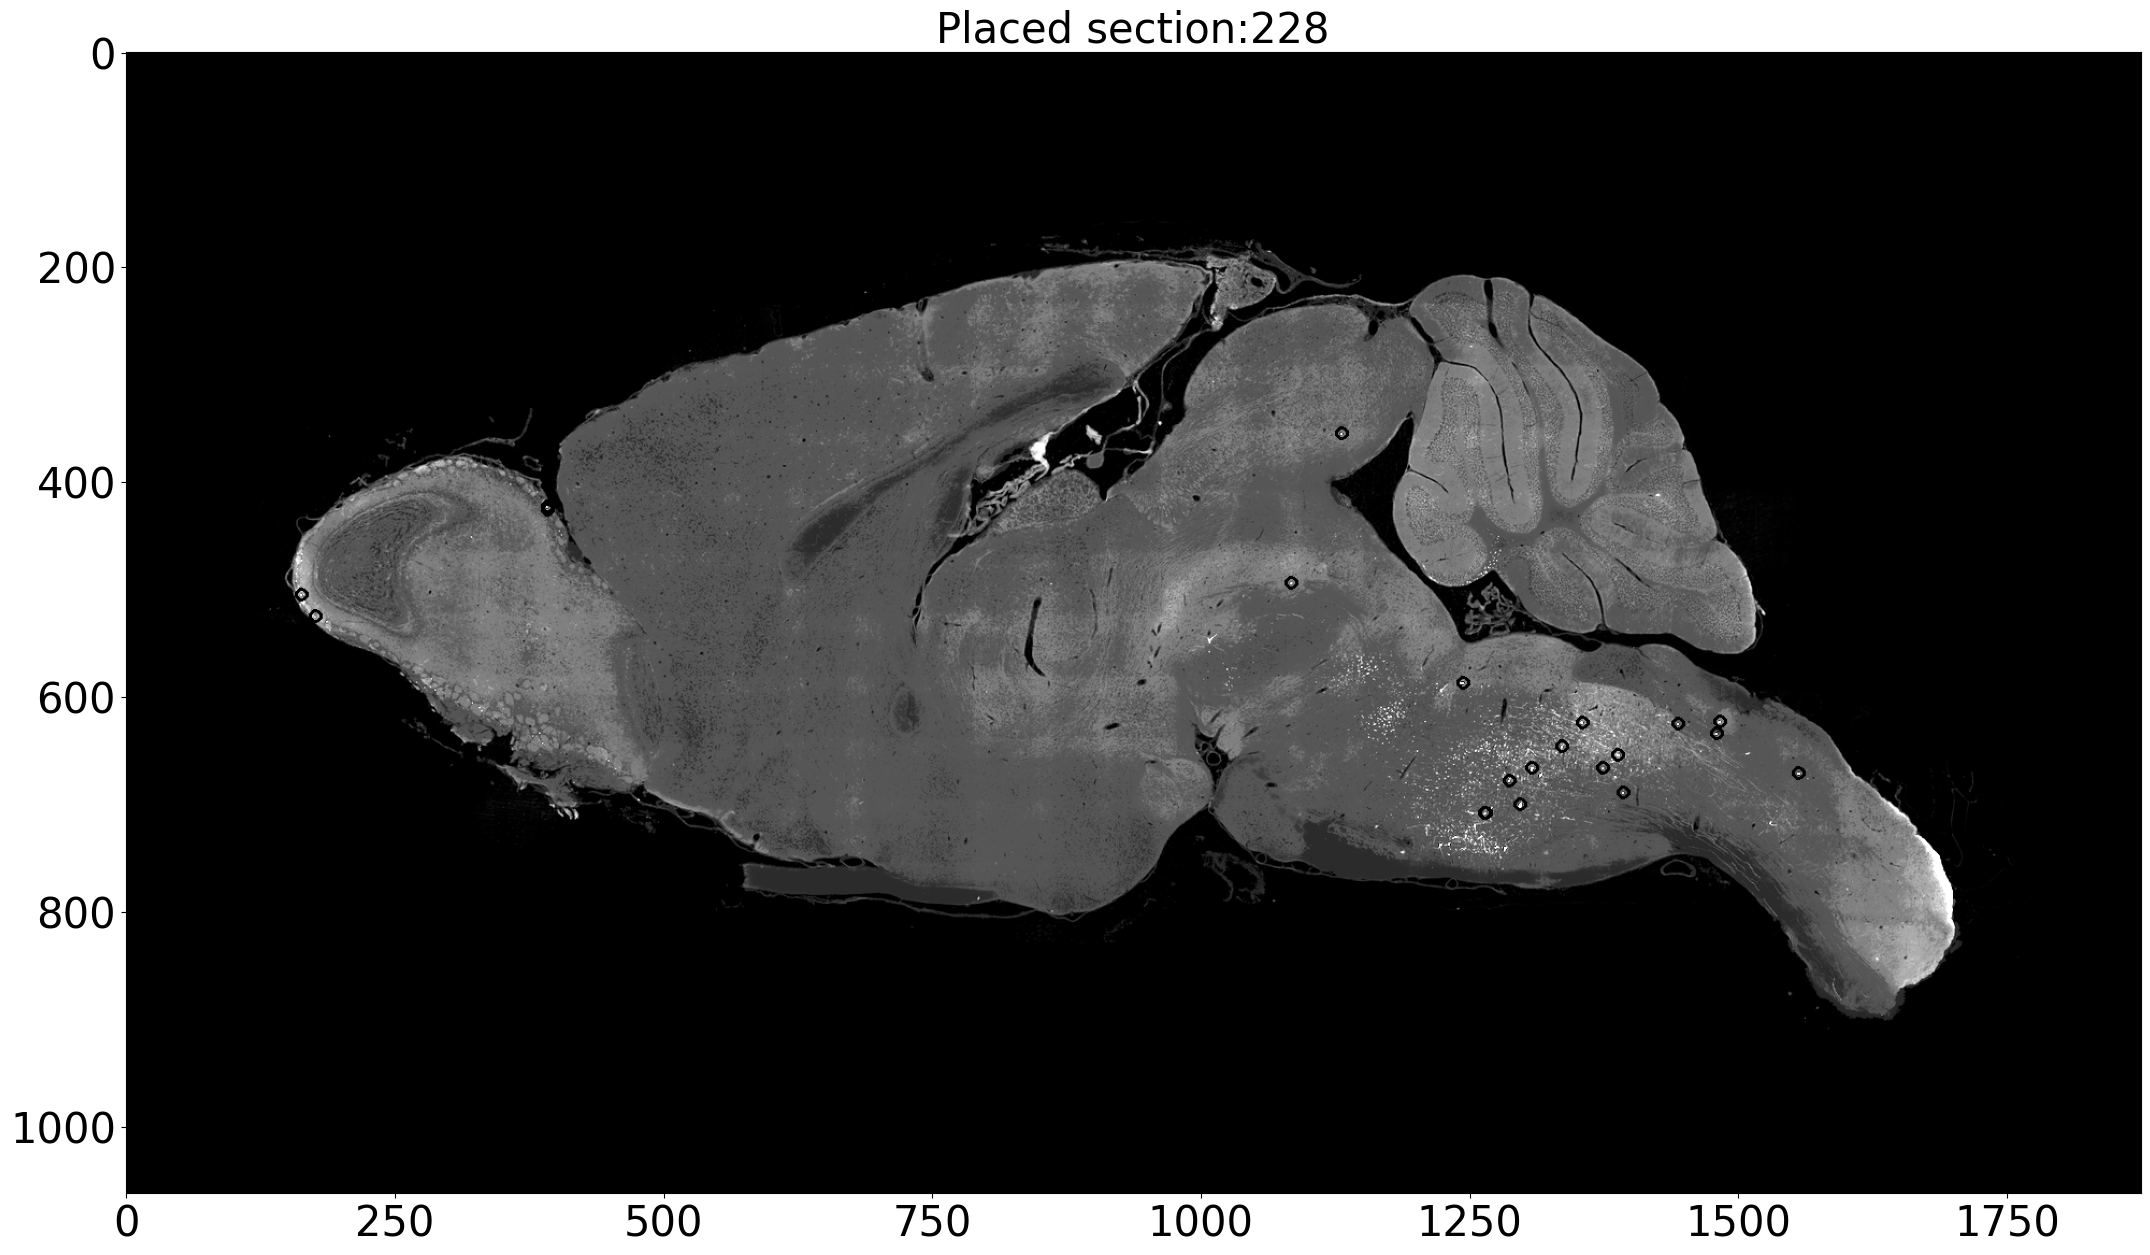

In [13]:
# test on image that has been rotated and placed in standard size
filename = f'{str(section_test_num).zfill(3)}.tif'
filepath = os.path.join(IMG_PATH, 'CH3/thumbnail_cleaned_normalized', filename)
img = cv2.imread(filepath, -1)
points = cleaned_section_points[section_test_num]
for point in points:
    x = point[0]
    y = point[1]
    #print(x,y)
    cv2.circle(img, (int(x), int(y)), radius, color, 2)
outpath = os.path.join(IMG_PATH,'CH3',f'{section_test_num}.cleaned.out.tif')
cv2.imwrite(outpath, img)
fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img, cmap="gray")
plt.title('Placed section:{}'.format(section_test_num), fontsize=30)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.show()

## Reproduce create_alignment transform

In [14]:
transforms = parse_elastix(animal)
warp_transforms = create_warp_transforms(animal, transforms, downsample=True)
ordered_transforms = sorted(warp_transforms.items())

section_transform = {}
for filename, transform in ordered_transforms:
    section_num = int(filename.split('.')[0])
    transform = np.linalg.inv(transform) 
    section_transform[section_num] = transform

## Alignment of annotation coordinates

In [15]:
aligned_section_points = defaultdict(list)
for section_num, vertices in cleaned_section_points.items():
    points = transform_create_alignment(vertices, section_transform[section_num]) # create_alignment transform
    aligned_section_points[section_num] = points    

In [16]:
points = aligned_section_points[section_test_num]
print(section_test_num)
print(len(points))

228
23


In [17]:
data = []
resolution = 0.325
for section_num,v in aligned_section_points.items():
    #print(section_num, len(v))
    for x,y in v:
        data.append([x*downsample_factor,y*downsample_factor,section_num])    

df = pd.DataFrame(data, columns=['x','y','section'])
df = df.astype({'section':'int32','x': 'float64', 'y':'float64'})
outfile = f'/net/birdstore/Active_Atlas_Data/data_root/atlas_data/DK55/cshl2dk.aligned.csv'
df.to_csv(outfile, index=False, header=False)
df.head()

,x,y,section
0,24865.850264,8007.602810,221
1,24881.847392,8007.905960,221
2,24598.376524,8610.643271,221
3,24603.833221,8322.694970,221
4,24439.617844,8543.623261,221


To this point, aligned_section_structure_polygons variable contains the aligned polygon vertices for each structure in each section. 
From now on, we introduce how to draw these points to numpy array or neuroglancer

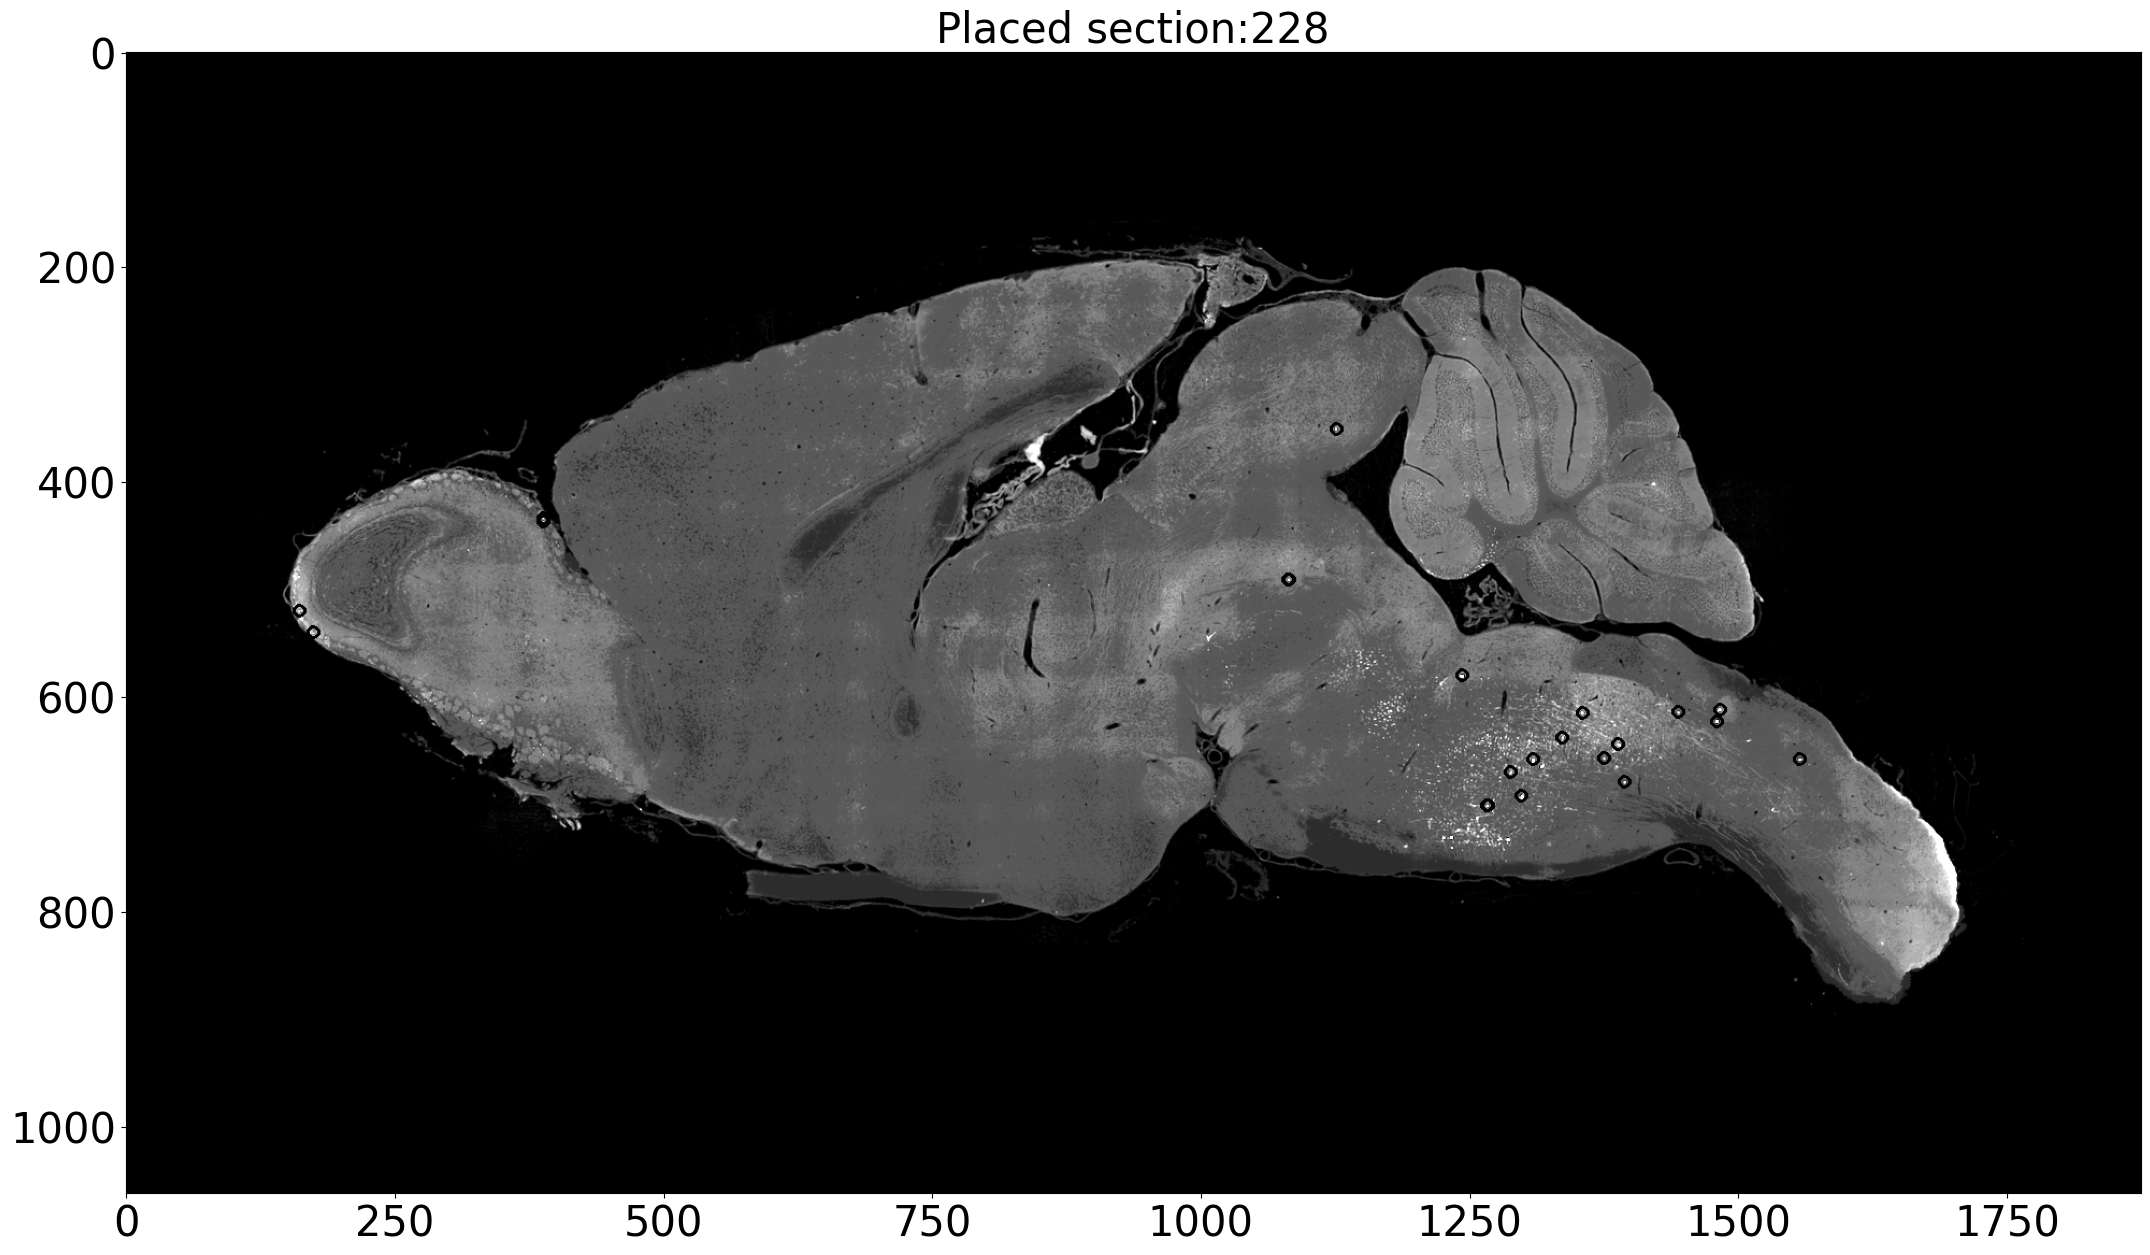

In [18]:
# test on image that has been rotated and placed in standard size
filename = f'{str(section_test_num).zfill(3)}.tif'
filepath = os.path.join(IMG_PATH, 'CH3/thumbnail_aligned_normalized', filename)
img = cv2.imread(filepath, -1)
points = aligned_section_points[section_test_num]
for point in points:
    x = point[0]
    y = point[1]
    #print(x,y)
    cv2.circle(img, (int(x), int(y)), radius, color, 2)
outpath = os.path.join(IMG_PATH,'CH3',f'{section_test_num}.aligned.out.tif')
cv2.imwrite(outpath, img)
fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img, cmap="gray")
plt.title('Placed section:{}'.format(section_test_num), fontsize=30)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.show()